### Import Libraries

In [406]:
# Core PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# NumPy
import numpy as np

# (Optional) Progress bar and visualization
from tqdm import tqdm
import matplotlib.pyplot as plt  # For plotting loss/accuracy curves

# (Optional) If you read/write data from files
import os
import json
import csv

### Data Preprocessing

Find dataset sizes

In [407]:
max_points = 0
max_columns = 0

with open("dataset/augmented_data.csv", "r") as file:
    for line in file:
        parts = line.strip().split(",")
        label = parts[0]  # e.g., 'heart'
        coordinates = parts[1:]
        
        num_coords = len(coordinates) // 2  # number of (x, y) pairs
        max_points = max(max_points, num_coords)
        max_columns = max(max_columns, len(parts))

print(f"Maximum number of (x, y) coordinate pairs: {max_points}")
print(f"Maximum number of columns in a row (including label): {max_columns}")


Maximum number of (x, y) coordinate pairs: 385
Maximum number of columns in a row (including label): 771


One hot encoding and padding

In [408]:
label_map = {"heart": 0, "circle": 1}  # Add more if needed
max_columns = 771
max_coords = max_columns - 1  # 802 coordinate values (x,y pairs)

input_file = "dataset/augmented_data.csv"
output_file = "dataset/processed_sequences.csv"

with open(input_file, "r") as infile, open(output_file, "w", newline="") as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    
    for row in reader:
        label_str = row[0]
        coords_str = row[1:]
        
        # Encode label
        label = label_map.get(label_str, -1)  # unknown labels get -1
        
        # Convert coordinates to float
        coords = list(map(int, coords_str))
        
        # Pad with zeros to max_coords
        if len(coords) < max_coords:
            coords += [0.0] * (max_coords - len(coords))
        else:
            coords = coords[:max_coords]  # truncate if needed
        
        # Write row: label + padded coords
        writer.writerow([label] + coords)

print(f"Processed data saved to '{output_file}'")

Processed data saved to 'dataset/processed_sequences.csv'


In [409]:
with open(output_file, "r") as infile:
    reader = csv.reader(infile)
    row_lengths = [len(row) for row in reader]

unique_lengths = set(row_lengths)
print(f"Unique row lengths: {unique_lengths}")
if len(unique_lengths) == 1:
    print("All rows have the same shape.")
else:
    print("Rows have different shapes.")

Unique row lengths: {771}
All rows have the same shape.


### Dataset class and Data Loading

dataset class

In [410]:
class CoordinateDataset(Dataset):
    def __init__(self, csv_file, max_len = 771, image_width=1280, image_height=720):
        self.data = []
        self.labels = []

        self.image_width = image_width
        self.image_height = image_height

        with open(csv_file, "r") as file:
            reader = csv.reader(file)
            for row in reader:
                label = int(row[0])
                coords = list(map(float, row[1:]))

                self.data.append(coords)
                self.labels.append(label)

        self.max_len = max_len


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        seq = self.data[idx]
        data = torch.tensor(seq, dtype=torch.float32).reshape(-1, 2)

        # Normalize: X / 1280, Y / 720
        data[:, 0] = data[:, 0] / self.image_width   # Normalize X
        data[:, 1] = data[:, 1] / self.image_height  # Normalize Y
        
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return data, label

In [411]:
dataset = CoordinateDataset("dataset/processed_sequences.csv")

print("Data shape:", dataset[0][0].shape)     # Should be (N, 2)
print("Label shape:", dataset[0][1].shape)   # Should be torch.Size([]) for scalar label

Data shape: torch.Size([385, 2])
Label shape: torch.Size([])


loading dataset as an obejct

In [412]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [413]:
for s, l in dataloader:
    print("Batch sequences shape:", s.shape)
    print("Batch labels shape:", l.shape)
    break

print(dataloader.batch_size)

Batch sequences shape: torch.Size([8, 385, 2])
Batch labels shape: torch.Size([8])
8


### Deep Learning Model

In [414]:
class ConvLSTMClassifier(nn.Module):
    def __init__(self, input_dim=2, conv_out_channels=32, lstm_hidden=64, lstm_layers=1):
        super(ConvLSTMClassifier, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=conv_out_channels, kernel_size=5, padding=2)
        self.reLU = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.lstm = nn.LSTM(
            input_size=conv_out_channels, 
            hidden_size=lstm_hidden, 
            num_layers=lstm_layers, 
            batch_first=True
        )

        self.fc = nn.Linear(lstm_hidden, 1)


    def forward(self, x):
         
        x = x.permute(0, 2, 1) 
        x = self.conv1(x)
        x = self.reLU(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1)  # Change shape to (batch_size, seq_len, features)
        x, _ = self.lstm(x)  # LSTM expects (batch_size, seq_len, features)
        x = x[:, -1, :]
        x = self.fc(x)

        return x

Test run of the model

In [415]:
images = torch.randn(8, 385, 2)  # Example input: batch of 8 sequences, each with 771 (x,y) pairs
model = ConvLSTMClassifier()
output = model(images)
output.shape

torch.Size([8, 1])

### Training Loop

Load data, Define model, Optimizer

In [416]:
batch_size = 8
learning_rate = 1e-3
epochs = 300

In [417]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ConvLSTMClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

Using device: cuda


In [418]:
avg_loss_overtime = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, label in dataloader:
        images = images.to(device)
        label = label.to(device).unsqueeze(1)  # Ensure label shape is (B, 1) for binary classification

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, label)

        # Print loss for tracking

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    avg_loss_overtime.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")


Epoch [1/300], Average Loss: 0.6946
Epoch [2/300], Average Loss: 0.6934
Epoch [3/300], Average Loss: 0.7016
Epoch [4/300], Average Loss: 0.6977
Epoch [5/300], Average Loss: 0.6960
Epoch [6/300], Average Loss: 0.6951
Epoch [7/300], Average Loss: 0.6937
Epoch [8/300], Average Loss: 0.6938
Epoch [9/300], Average Loss: 0.6883
Epoch [10/300], Average Loss: 0.6874
Epoch [11/300], Average Loss: 0.6862
Epoch [12/300], Average Loss: 0.6589
Epoch [13/300], Average Loss: 0.6544
Epoch [14/300], Average Loss: 0.6503
Epoch [15/300], Average Loss: 0.6540
Epoch [16/300], Average Loss: 0.6513
Epoch [17/300], Average Loss: 0.6458
Epoch [18/300], Average Loss: 0.6446
Epoch [19/300], Average Loss: 0.6452
Epoch [20/300], Average Loss: 0.6378
Epoch [21/300], Average Loss: 0.6010
Epoch [22/300], Average Loss: 0.5642
Epoch [23/300], Average Loss: 0.5946
Epoch [24/300], Average Loss: 0.5629
Epoch [25/300], Average Loss: 0.5324
Epoch [26/300], Average Loss: 0.6151
Epoch [27/300], Average Loss: 0.5618
Epoch [28/

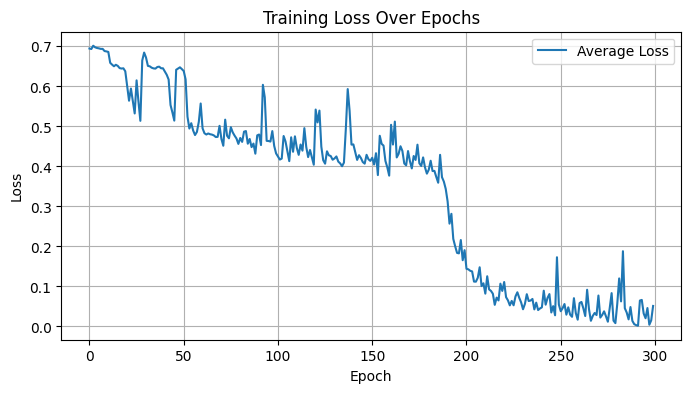

In [419]:
plt.figure(figsize=(8, 4))
plt.plot(avg_loss_overtime, label="Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [420]:
# Save the trained model's state_dict
torch.save(model.state_dict(), "convlstm_classifier.pth")
print("Model saved to convlstm_classifier.pth")

Model saved to convlstm_classifier.pth
